# CS579: Lecture 17  

**Text Regression II**  
*[Dr. Aron Culotta](http://cs.iit.edu/~culotta)*  
*[Illinois Institute of Technology](http://iit.edu)*

Today, we'll look more closely at the flu-tracking example.

In [197]:
RAW_DATA='tweets'  # I haven't placed this directory in GitHub, since it's so large.
# Data looks like this. (first 10 lines of second file)
! head `ls $RAW_DATA/* | head -1 `
# This is already tokenized.

nice exclamationpoint looking forward to seeing the piece on you twittelator dude exclamationpoint congratulations exclamationpoint 


In [52]:
# Read tweets. One file per day, one tweet per line.
# Store a list of Counter objects, tracking the frequency of terms for each day.
from collections import Counter
import glob
import io
import os
import subprocess
import sys

def read_data():
    counts = []
    dates = []
    lines = []
    # For demonstration purposes, we'll only read the first 10K lines of a file.
    max_lines = 10000
    for filename in glob.glob(RAW_DATA + '/*'):
        print 'reading', filename
        lines.append(file_length(filename))
        dates.append(os.path.basename(filename))
        this_counter = Counter()
        line_ct = 0
        for line in io.open(filename, 'rt', encoding='utf8'):
            this_counter.update(line.split())
            line_ct += 1
            if line_ct > max_lines:
                break
        print 'read %d tokens for %d words' % (sum(this_counter.values()), 
                                               len(this_counter.keys()))
        counts.append(this_counter)
    return counts, dates, lines
    

def file_length(filename):
    p = subprocess.Popen(['wc', '-l', filename], stdout=subprocess.PIPE, 
                                                  stderr=subprocess.PIPE)
    result, err = p.communicate()
    if p.returncode != 0:
        raise IOError(err)
    return int(result.strip().split()[0])

counts, dates, lines = read_data()

reading tweets/2009-08-20
read 15 tokens for 13 words
reading tweets/2009-09-01
read 112851 tokens for 14763 words
reading tweets/2009-09-02
read 113951 tokens for 15052 words
reading tweets/2009-09-03
read 114283 tokens for 14908 words
reading tweets/2009-09-04
read 112864 tokens for 14953 words
reading tweets/2009-09-05
read 110453 tokens for 15044 words
reading tweets/2009-09-06
read 109191 tokens for 14659 words
reading tweets/2009-09-07
read 112170 tokens for 14899 words
reading tweets/2009-09-08
read 107959 tokens for 14384 words
reading tweets/2009-09-09
read 112892 tokens for 14759 words
reading tweets/2009-09-10
read 111702 tokens for 14846 words
reading tweets/2009-09-11
read 110466 tokens for 14655 words
reading tweets/2009-09-12
read 109467 tokens for 14993 words
reading tweets/2009-09-13
read 110850 tokens for 14541 words
reading tweets/2009-09-14
read 105590 tokens for 13606 words
reading tweets/2009-09-15
read 111750 tokens for 14504 words
reading tweets/2009-09-16
read 

In [200]:
# Convert to np arrays.
import numpy as np

counts = np.array(counts)
dates = np.array(dates)
lines = np.array(lines)

In [ ]:
# Pickle everything
import pickle
pickle.dump((counts, dates, lines), open('data.pkl', 'wb'))
# ~73Mb

In [204]:
print '%d days of tweets' % len(dates)

243 days of tweets


In [205]:
print sum(sum(c.values()) for c in counts), 'total tokens'
words = set()
for c in counts:
    words.update(c.keys())
print len(words), 'total unique words'

26302164 total tokens
97329 total unique words


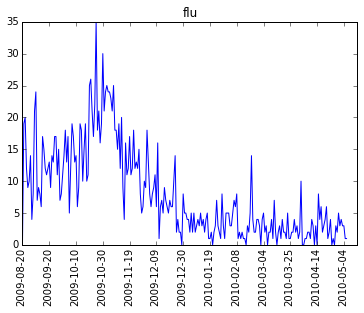

In [206]:
# Plot occurrences of 'flu'
import matplotlib.pyplot as plt

def get_trend(counts, term):
    return np.array([c[term] for c in counts])

def plot_trend(x, y, title):
    plt.figure()
    plt.plot(y)
    plt.xticks(range(len(x))[::20], x[::20], rotation='90')
    plt.title(title)
    plt.show()
    
flu_trend = get_trend(counts, 'flu')
plot_trend(dates, flu_trend, 'flu')


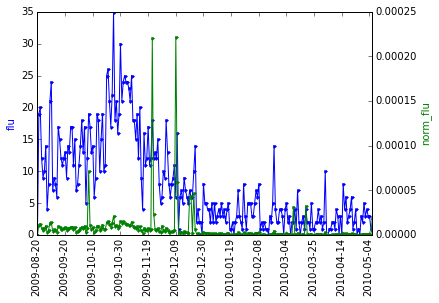

In [208]:
# Normalize by number of tweets per day.
norm_flu_trend = 1. * flu_trend / lines

def plot_trends(x, y1, y2, label1, label2):
    # Plot two trends with different y-scales
    fig, ax1 = plt.subplots()
    ax1.plot(y1, 'b.-', label=label1)
    ax1.set_ylabel(label1, color='b')
    plt.xticks(range(len(x))[::20], x[::20], rotation='90')
    ax2 = ax1.twinx()
    ax2.plot(y2, 'g.-', label=label2)
    ax2.set_ylabel(label2, color='g')
    plt.show()

plot_trends(dates, flu_trend, norm_flu_trend, 'flu', 'norm_flu')

** Need to smooth! **

We'll group by week rather than day to deal with the high variance of counts.

In [209]:
# Read CDC's ILI data, which looks like this:
!head ili.csv

2009-08-29,2009-09-05,0.03475
2009-09-05,2009-09-12,0.04060
2009-09-12,2009-09-19,0.04248
2009-09-19,2009-09-26,0.04189
2009-09-26,2009-10-03,0.04869
2009-10-03,2009-10-10,0.06076
2009-10-10,2009-10-17,0.07028
2009-10-17,2009-10-24,0.07688
2009-10-24,2009-10-31,0.07514
2009-11-01,2009-11-07,0.06615


In [210]:
ili_dates = [l.strip().split(',') for l in open('ili.csv')]
print ili_dates[0]

['2009-08-29', '2009-09-05', '0.03475']


In [211]:
# Sum together tweet data for each week.

def get_week_counts(counts, dates, ili_dates, lines):
    week_counts = []
    week_dates = []
    week_lines = []
    for start, end, value in ili_dates:
        week_dates.append(end)
        this_counts, this_lines = get_counts_in_range(counts, lines, dates, start, end)
        week_counts.append(this_counts)
        week_lines.append(this_lines)
    return np.array(week_counts), np.array(week_dates), np.array(week_lines)

def get_counts_in_range(counts, lines, dates, start, end):
    indices = [i for i, v in enumerate(dates) 
               if dates[i] > start and dates[i] <= end]
    print 'got %d dates from %s to %s' % (len(indices), start, end)
    sumc = Counter()
    for cts in counts[indices]:
        sumc.update(cts)
    return sumc, sum(lines[indices])
    
week_counts, week_dates, week_lines = get_week_counts(counts, dates, ili_dates, lines)

got 5 dates from 2009-08-29 to 2009-09-05
got 7 dates from 2009-09-05 to 2009-09-12
got 7 dates from 2009-09-12 to 2009-09-19
got 7 dates from 2009-09-19 to 2009-09-26
got 7 dates from 2009-09-26 to 2009-10-03
got 7 dates from 2009-10-03 to 2009-10-10
got 7 dates from 2009-10-10 to 2009-10-17
got 7 dates from 2009-10-17 to 2009-10-24
got 7 dates from 2009-10-24 to 2009-10-31
got 6 dates from 2009-11-01 to 2009-11-07
got 7 dates from 2009-11-07 to 2009-11-14
got 7 dates from 2009-11-14 to 2009-11-21
got 7 dates from 2009-11-21 to 2009-11-28
got 7 dates from 2009-11-28 to 2009-12-05
got 7 dates from 2009-12-05 to 2009-12-12
got 7 dates from 2009-12-12 to 2009-12-19
got 6 dates from 2009-12-19 to 2009-12-26
got 7 dates from 2009-12-26 to 2010-01-02
got 7 dates from 2010-01-02 to 2010-01-09
got 7 dates from 2010-01-09 to 2010-01-16
got 7 dates from 2010-01-16 to 2010-01-23
got 7 dates from 2010-01-23 to 2010-01-30
got 7 dates from 2010-01-30 to 2010-02-06
got 7 dates from 2010-02-06 to 201

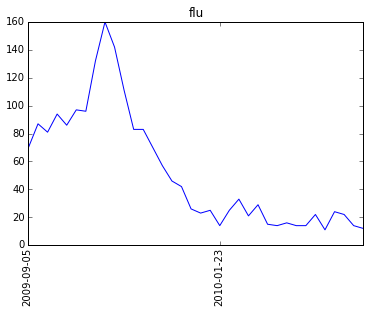

In [212]:
flu_trend = get_trend(week_counts, 'flu')
plot_trend(week_dates, flu_trend, 'flu')

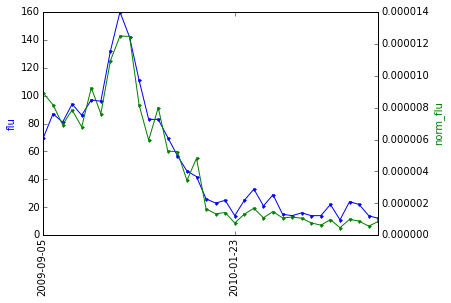

In [213]:
norm_flu_trend = 1. * flu_trend / week_lines
plot_trends(week_dates, flu_trend, norm_flu_trend, 'flu', 'norm_flu')

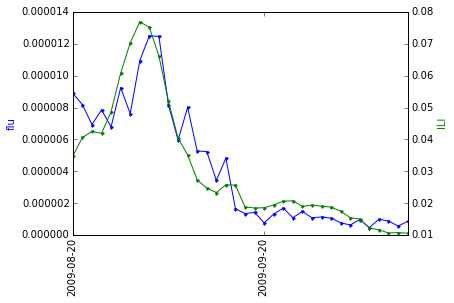

In [214]:
# Compare norm_flu_trend and ILI data
ilis = [float(v[2]) for v in ili_dates]
plot_trends(dates, norm_flu_trend, ilis, 'flu', 'ILI')

In [215]:
# What is correlation?
from scipy.stats.stats import pearsonr
print pearsonr(norm_flu_trend, ilis)

(0.92186448815003175, 1.4721218653313829e-15)


$$
r = \frac{\sum_{i=1}^n (x_i - \bar{x})(y_i - \bar{y})}{\left(\sum_{i=1}^n(x_i - \bar{x})^2\right)^.5  \left(\sum_{i=1}^n(y_i - \bar{y})^2\right)^.5}
$$

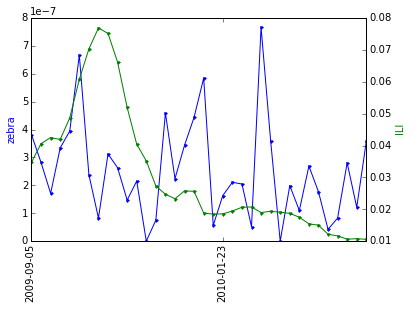

correlation for zebra (0.11135875119317874, 0.51789856630330067)


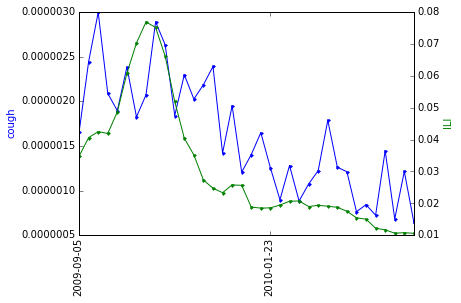

correlation for cough (0.73992319956590169, 2.5123341693956533e-07)


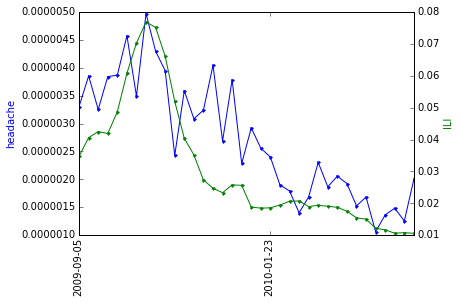

correlation for headache (0.81506787372637202, 1.4331660744340132e-09)


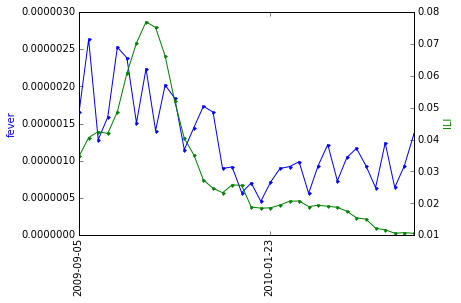

correlation for fever (0.69213469769648095, 2.9244777232518385e-06)


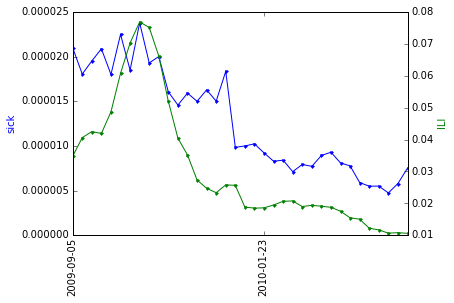

correlation for sick (0.85208866376956682, 4.3486363046679577e-11)


In [216]:
# Try some other terms.
def evaluate_terms(terms, week_counts, week_lines, week_dates, ilis):
    for term in terms:
        trend = 1. * get_trend(week_counts, term) / week_lines
        plot_trends(week_dates, trend, ilis, term, 'ILI')
        print 'correlation for', term, pearsonr(trend, ilis)

evaluate_terms(['zebra', 'cough', 'headache', 'fever', 'sick'], week_counts, week_lines, week_dates, ilis)

slope= [ 4875.46999025] intercept= 0.0111974820114


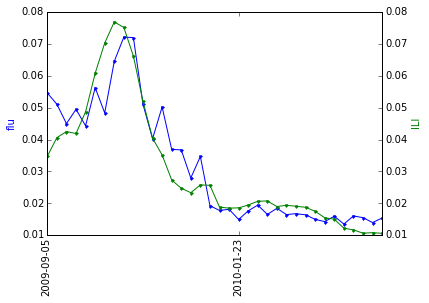

correlation: (0.88896023873430152, 1.3017011234610459e-09)
mse= 0.00536794341945


In [217]:
# Fit a model on first N weeks, then predict on remaining.
from sklearn.linear_model import LinearRegression
import math

def train_test(trend, ilis, dates, train_size):
        reg = LinearRegression()
        x = [[i] for i in trend]
        reg.fit(x[:train_size], ilis[:train_size])
        print 'slope=', reg.coef_, 'intercept=', reg.intercept_
        train_preds = reg.predict(x[:train_size])
        test_preds = reg.predict(x[train_size:])
        all_preds = np.concatenate((train_preds, test_preds))
        plot_trends(dates, all_preds, ilis, 'flu', 'ILI')
        print 'correlation:', pearsonr(test_preds, 
                                       ilis[train_size:])
        print 'mse=', math.sqrt(np.mean((test_preds -
                                    ilis[train_size:])**2))
    
train_test(norm_flu_trend, ilis, week_dates, 10)

coef= [ 5251.82254491   -84.69640503 -1916.69957167   875.47184323] intercept= -0.0061411779179


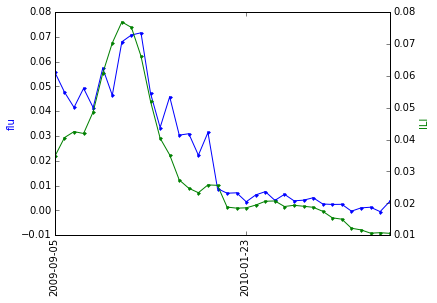

correlation: 0.717677334484


In [218]:
def train_test_multi(trends, ilis, dates, train_size):
        reg = LinearRegression()
        x = []
        for i in range(len(trends[0])):
            x.append([trends[j][i] for j in range(len(trends))])
        reg.fit(x[:train_size], ilis[:train_size])
        print 'coef=', reg.coef_, 'intercept=', reg.intercept_
        train_preds = reg.predict(x[:train_size])
        test_preds = reg.predict(x[train_size:])
        all_preds = np.concatenate((train_preds, test_preds))
        plot_trends(dates, all_preds, ilis, 'flu', 'ILI')
        corr = pearsonr(test_preds, ilis[train_size:])
        print 'correlation:', corr[0]
        return corr[0]
    
fever = 1. * get_trend(week_counts, 'fever') / week_lines
cough = 1. * get_trend(week_counts, 'cough') / week_lines
sick = 1. * get_trend(week_counts, 'sick') / week_lines

corr = train_test_multi([norm_flu_trend, fever, cough, sick],
                     ilis, week_dates, 15)

## Searching for term combinations

Given a list of $N$ potential terms to track, we want to search for the subset that results in the most accurate model.

Assume we have a training set $D_t$ and a validation set $D_v$ of tweets and CDC values.

A common iterative feature selection strategy is as follows:

Let $F = \{\}$ be the set of terms used in the regression model.

Let $T=\{t_1 \ldots t_N\}$ be the set of possible terms to use.

1. For $t \in T$:
  1. Let $F = F \cup \{t\}$ (i.e., add $t$ to $F$)
  2. Fit the model on $D_t$
  3. Evaluate the model on $D_v$
2. Pick the term that resulted in the best score on $D_v$ and add it to $F$.
3. Repeat as long as the model's accuracy improves.
